In [1]:
from __future__ import annotations
import datetime as dt
from typing import NamedTuple
from collections.abc import Iterable
from dataclasses import replace
from random import random
import sys
import apsw

from tuplesaver.engine import Engine
from tuplesaver.RM import Roww
from tuplesaver.adaptconvert import included_adapt_convert_types
from typing import cast
from IPython.display import display

# Models

In [2]:
class MyModel(Roww):
    name: str
    date: dt.datetime
    score: float | None

Connect to the database and create tables with an `Engine`

In [3]:
engine = Engine(":memory:")
# engine = Engine("example.db")
engine.adapt_convert_registry.register_included_adaptconverters(included_adapt_convert_types)
engine.ensure_table_created(MyModel)
engine.connection # just the real apsw connection object

# Basic CRUD

## Insert row

In [4]:
row = MyModel("Bart", dt.datetime.now(), 6.5)
row = engine.save(row)
row

MyModel(id=1, name='Bart', date=datetime.datetime(2026, 1, 18, 23, 26, 31, 234948), score=6.5)

## Find row by id

In [5]:
engine.find(MyModel, row.id)

MyModel(id=1, name='Bart', date=datetime.datetime(2026, 1, 18, 23, 26, 31, 234948), score=6.5)

## Find row by Field

In [6]:
engine.find_by(MyModel, name= "Bart")

MyModel(id=1, name='Bart', date=datetime.datetime(2026, 1, 18, 23, 26, 31, 234948), score=6.5)

## Update row

In [7]:
engine.save(replace(row, score=78.9))

MyModel(id=1, name='Bart', date=datetime.datetime(2026, 1, 18, 23, 26, 31, 234948), score=78.9)

## Delete row

by id

In [8]:
row2 = engine.save(MyModel("foo", dt.datetime.now(), 6.5))

engine.delete(MyModel, row2.id)

by instance

In [9]:
row3 = engine.save(MyModel("bar", dt.datetime.now(), 9.5))

engine.delete(row3)

# Foreign Keys Relationships
Models can be related by using a model as a field type in another model.

In [10]:
class Band(Roww):
    name: str
    active: bool

class BandMember(Roww):
    band: Band
    name: str
    instrument: str

engine.ensure_table_created(Band)
engine.ensure_table_created(BandMember)

You can save a model and then use it as a related field in another model.

In [11]:
devo = engine.save(Band("Devo", True))
mark = engine.save(BandMember(devo, "Mark Mothersbaugh", "Keyboards"))

## Lazy loading
FK related models are lazy loaded by default.

In [12]:
singer = engine.find(BandMember, mark.id)
display(singer)
display(singer.name)
# Note how the `band` field gets lazy loaded
display(singer.band.name)

BandMember(id=1, band=Band(id=1, name='Devo', active=True), name='Mark Mothersbaugh', instrument='Keyboards')

'Mark Mothersbaugh'

'Devo'

## Save/Find `deep`ly

When saving related models, you can use the `deep=True` argument to recursively `save`/`find` related models.

Recursively `save`/`find` related models. Rows without an `id` will be inserted, rows with an `id` will be updated.

In [13]:
from pandas.tests.indexing.multiindex.test_indexing_slow import b
beatles = Band("The Band", True) # unsaved
beatles = engine.save(beatles)

paul = BandMember(beatles, "Paul McCartney", "Bass") # unsaved

# saves both the band and the member, recursively
paul = engine.save(paul)

In [14]:
beatles = engine.find(BandMember, paul.id)

display(beatles) # Note how the `band` fields model is eagerly recursively loaded.

BandMember(id=2, band=Band(id=2, name='The Band', active=True), name='Paul McCartney', instrument='Bass')

Dummy data for later, also demonstrates multi-level relationships.

In [15]:
class League(Roww):
    leaguename: str

class Team(Roww):
    teamname: str
    league: League

class Athlete(Roww):
    name: str
    team: Team


engine.ensure_table_created(League)
engine.ensure_table_created(Team)
engine.ensure_table_created(Athlete)

with engine.connection:  # transaction
    # Insert dummy data
    leagues = [
        engine.save(League("Big")),
        engine.save(League("Small")),
        ]
    teams = [
        engine.save(Team("Red", leagues[0])),
        engine.save(Team("Ramble", leagues[1])),
        engine.save(Team("Blue", leagues[0])),
        engine.save(Team("Green", leagues[1])),
        ]
    players = [
        alice:=engine.save(Athlete("Alice", teams[0])),
        engine.save(Athlete("Bob", teams[0])),
        engine.save(Athlete("Charlie", teams[1])),
        engine.save(Athlete("Dave", teams[2])),
        engine.save(Athlete("Beth", teams[3])),
        engine.save(Athlete("Frank", teams[2])),
    ]

In [16]:
engine.find_by(Athlete, name="Alice").team.league.leaguename

'Big'

## Ad-hoc models and the `Any` type
Models can also be completely ad-hoc, where you provide the sql. These models do not require an `id` field. They also have a special field type available, `Any`, which can be used to represent any type of data. This is particularly useful for dynamic or polymorphic data structures where the exact type may not be known until runtime.


In [17]:
from typing import Any

class TableInfo(NamedTuple):
    cid: int
    name: str
    type: str
    notnull: int
    dflt_value: Any # `Any` will return raw value matching python's bare sqlite3, without conversion
    pk: int

sql = f"PRAGMA table_info({Athlete.__name__})"

cols = engine.query(TableInfo, sql).fetchall()
for col in cols:
    print(f"{col.cid:2d} {col.name:10s} {col.type:10s} {str(col.dflt_value or 'None'):10s}")

 0 id         INTEGER    None      
 1 name       TEXT       None      
 2 team       Team_ID    None      


# Querying

The interface for querying is very simple, you can use any arbitrary SQL directly.

```python
engine.query(Model, sql)
```

In [18]:
class AverageScoreResults(NamedTuple):
    avg_score: float
    scorecount: int

sql = 'SELECT avg(score), count(*) FROM MyModel'

result = engine.query(AverageScoreResults, sql).fetchone()
assert result is not None

print(f'The table has {result.scorecount} rows, with and average of {result.avg_score:0.2f}')

The table has 1 rows, with and average of 78.90


`select` is a simple yet powerful way to retrieve Models from the database.

The most simple case selects all rows from a table.

`select` returns a tuple of `(Model, query)`, matching the `engine.query` interface.


In [19]:
from tuplesaver.sql import select

M, q = select(Athlete)

for player in engine.query(M, q).fetchall():
    print(player)


Athlete(id=1, name='Alice', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))
Athlete(id=2, name='Bob', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))
Athlete(id=3, name='Charlie', team=Team(id=2, teamname='Ramble', league=League(id=2, leaguename='Small')))
Athlete(id=4, name='Dave', team=Team(id=3, teamname='Blue', league=League(id=1, leaguename='Big')))
Athlete(id=5, name='Beth', team=Team(id=4, teamname='Green', league=League(id=2, leaguename='Small')))
Athlete(id=6, name='Frank', team=Team(id=3, teamname='Blue', league=League(id=1, leaguename='Big')))


For brevity, inline `select(Model)` and `*`splat the `(M,q)` tuple right into `engine.query`.

In [20]:
for player in engine.query(*select(Athlete)).fetchall():
    print(player)

Athlete(id=1, name='Alice', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))
Athlete(id=2, name='Bob', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))
Athlete(id=3, name='Charlie', team=Team(id=2, teamname='Ramble', league=League(id=2, leaguename='Small')))
Athlete(id=4, name='Dave', team=Team(id=3, teamname='Blue', league=League(id=1, leaguename='Big')))
Athlete(id=5, name='Beth', team=Team(id=4, teamname='Green', league=League(id=2, leaguename='Small')))
Athlete(id=6, name='Frank', team=Team(id=3, teamname='Blue', league=League(id=1, leaguename='Big')))


The select query can easily be modified to add `WHERE` clauses.

> **Note:** These `def`s never actually run, but instead are analyzed through reflection to build the query.

```python

In [21]:
@select(Athlete)
def athletes_named_beth():
    return f"WHERE {Athlete.name} LIKE 'B%'"

for player in engine.query(*athletes_named_beth()).fetchall():
    print(player)

Athlete(id=2, name='Bob', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))
Athlete(id=5, name='Beth', team=Team(id=4, teamname='Green', league=League(id=2, leaguename='Small')))


Joins are automatically determined by the field path (e.g. `Athlete.team.name`). The `Model` class referenced by the `select` must always be the root of your field path.

In [22]:
# a single join
@select(Athlete)
def athletes_on_red_team():
    return f"WHERE {Athlete.team.teamname} = 'Red'"

# two joins required
@select(Athlete)
def athletes_in_big_leagues():
    return f"WHERE {Athlete.team.league.leaguename} = 'Big'"


for player in engine.query(*athletes_on_red_team()).fetchall():
    print(player)

for player in engine.query(*athletes_in_big_leagues()).fetchall():
    print(player)

Athlete(id=1, name='Alice', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))
Athlete(id=2, name='Bob', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))
Athlete(id=1, name='Alice', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))
Athlete(id=2, name='Bob', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))
Athlete(id=4, name='Dave', team=Team(id=3, teamname='Blue', league=League(id=1, leaguename='Big')))
Athlete(id=6, name='Frank', team=Team(id=3, teamname='Blue', league=League(id=1, leaguename='Big')))


# Querys requiring backrefs

Eventually we will support backrefs:

```python
class League(Roww):
    id: int | None
    leaguename: str
    teams: List[Team] # backref will be something like this
```

And then you could do:

```python
@select(League)
def leagues_with_big_teams():
    return f"WHERE {League.teams.teamname} = 'Big'"
```

For now just fallback to raw queries: 


In [23]:
sql = "SELECT * FROM League JOIN Team ON Team.league = League.id WHERE Team.teamname = 'Big'"
result = engine.query(League, sql).fetchone()


## Query Parameters
The decorated function can also take parameters which will be return as a third element in the tuple.

In [24]:
@select(Athlete)
def athletes_in_league(league: str):
    return f"WHERE {Athlete.team.league.leaguename} = {league}"

M, q, p = athletes_in_league('Big')

print("Our query:")
print(q)
print(p)
print()

for player in engine.query(M, q, p).fetchall():
    print(player)

# or the same, but more concisely
for player in engine.query(*athletes_in_league('Small')).fetchall():
    print(player)

Our query:
SELECT Athlete.id, Athlete.name, Athlete.team FROM Athlete
JOIN Team team ON Athlete.team = team.id
JOIN League team_league ON team.league = team_league.id
WHERE team_league.leaguename = :league
{'league': 'Big'}

Athlete(id=1, name='Alice', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))
Athlete(id=2, name='Bob', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))
Athlete(id=4, name='Dave', team=Team(id=3, teamname='Blue', league=League(id=1, leaguename='Big')))
Athlete(id=6, name='Frank', team=Team(id=3, teamname='Blue', league=League(id=1, leaguename='Big')))
Athlete(id=3, name='Charlie', team=Team(id=2, teamname='Ramble', league=League(id=2, leaguename='Small')))
Athlete(id=5, name='Beth', team=Team(id=4, teamname='Green', league=League(id=2, leaguename='Small')))


## SQLite3 Cursor
Notice that query returns a real `sqlite3.Cursor`, you can use it to `fetchall`, `fetchone`, `fetchmany`, etc.

The only thing we do is set the `Cursor.row_factory` to return Model instances, and stub the static typehints in for them as well.

In [25]:
engine.query(*select(Athlete)).fetchone()

Athlete(id=1, name='Alice', team=Team(id=1, teamname='Red', league=League(id=1, leaguename='Big')))

# Persisting native python collections
You can persist any list or dict that recusively serializes to valid JSON using the `json.dumps'and `json.loads` methods. Enums will be supported in the future.

In [26]:
class JsonExample(Roww):
    names: dict

engine.ensure_table_created(JsonExample)
names = {"Alice": 1, "Bob": 2, "Charlie": 3}
row = engine.save(JsonExample(names))

engine.find(JsonExample, row.id)

JsonExample(id=1, names={'Alice': 1, 'Bob': 2, 'Charlie': 3})

## SQLite3 supports JSON extensions

In [27]:
class Character(Roww):
    name: str
    stats: dict

engine.ensure_table_created(Character)

engine.save(Character('Harbel', {'spell': 'Fireball', 'level': 3}))
engine.save(Character('Quenswen', {'spell': 'Waterspout', 'level': 27}))
engine.save(Character('Ruthbag', {'spell': 'Fireball', 'level': 12}))

@select(Character)
def get_fireball_characters():
    f"WHERE {Character.stats} ->> '$.spell' = 'Fireball'"

for c in engine.query(*get_fireball_characters()).fetchall():
    print(f"{c.name} has a fireball at level {c.stats['level']}")

Harbel has a fireball at level 3
Ruthbag has a fireball at level 12


# Persisting Custom Types: Adapt/Convert

In [28]:
class PhoneNumber:
    def __init__(self, area_code: int, number: int):
        self.area_code = area_code
        self.number = number

    def __repr__(self):
        return f"PhoneNumber({self.area_code}, {self.number})"

def adapt_phonenumber(obj: PhoneNumber) -> str:
    return f"({obj.area_code}) {obj.number}"

def convert_phonenumber(data: apsw.SQLiteValue) -> PhoneNumber:
    area_code, number = cast(str, data).split(" ", 1)
    return PhoneNumber(int(area_code.strip("()")), int(number))

# register_adapt_convert(PhoneNumber, adapt_phonenumber, convert_phonenumber, overwrite=True)
engine.adapt_convert_registry.register_adapt_convert( PhoneNumber, adapt_phonenumber, convert_phonenumber)



class LibraryMember(Roww):
    name: str
    pnumber: PhoneNumber

engine.ensure_table_created(LibraryMember)
row2 = LibraryMember("Alice", PhoneNumber(123, 4567890))

row2 = engine.save(row2)

engine.find(LibraryMember, row2.id)

LibraryMember(id=1, name='Alice', pnumber=PhoneNumber(123, 4567890))

There is a special helper function for the common case of pickleable types, like `pandas.DataFrame`, `numpy.ndarray`, etc.

In [29]:
import pandas as pd


class DataAnalysis(Roww):
    name: str
    df: pd.DataFrame

engine.adapt_convert_registry.register_pickleable_adapt_convert(pd.DataFrame)
engine.ensure_table_created(DataAnalysis)

df = pd.DataFrame({"a": [1, 2, 3], "b": [4, 5, 6]})
row = engine.save(DataAnalysis("foo", df))

engine.find(DataAnalysis, row.id).df

,a,b
0,1,4
1,2,5
2,3,6


# Performance scenarios
Every call to insert real full trip to the db. The data is ready to be queried immediately, in SQLAlchemy parlance, 'flushed'. Committig ends the implicit transaction and ensures that the data is persisted to disk. Data is then avialable to other connections e.g. other worker processes

Because the db and app share a process, the performance is good enough that you can basically ignore the N+1 problem. This also simplifies implementation of this library, no need to track session etc. It also simplifies your app as data is syncronized immediately with the database, thus eliminates the need for a stateful cache, a source off many bugs and complexity.

In [30]:
# engine.connection.set_trace_callback(None) # disable echo SQL

## Insert many (17,000 rows)

In [31]:
rows = [MyModel("foo", dt.datetime.now(), random()*100) for _ in range(17000)]

In [32]:
with engine.connection:  # transaction
    for r in rows:
        engine.save(r)


## Update many (17,000 rows)

In [33]:
rows = [replace(row, date=dt.datetime.now(), score=random()*100) for row in rows]

In [34]:
with engine.connection:  # transaction
    for r in rows:
        engine.save(r)


## Query many

In [35]:
def print_30_per_line(ss: Iterable[str]):
    for i,s in enumerate(ss, 1):
        print(s, end=" ")
        if i % 30 == 0:
            print()
    print()

@select(MyModel)
def high_scores():
    return f"WHERE {MyModel.score} > 95.7"

rows = engine.query(*high_scores()).fetchall()
print_30_per_line(f"{r.score:5.1f}" for r in rows)

 97.1  99.6  98.4  97.9  96.9  99.0  99.8  96.6  97.2  96.8  98.0  97.9  99.4  95.8  96.5  99.9  97.8  99.6  99.3  98.3  95.7  97.6  96.3  96.5  96.1  96.5  98.4  97.8  96.4  98.5 
 99.9  99.9  96.3  96.3  99.0  97.4  99.3  96.1  98.5  98.9  98.3  96.9  98.0  98.7  96.9  95.8  96.9  97.0  98.5  98.3  98.0  96.3  95.8  97.5  96.2  99.4  98.4  96.8  97.0  99.9 
 99.9  99.8  97.8  96.8  98.9  98.6  99.8  96.8  98.8  98.4  95.8  99.7  97.7  96.2  98.7  98.5  99.2  97.1  96.6  98.2  98.5  97.7  96.6  98.8  97.8  98.9  97.5  97.9  98.5  98.8 
 97.1  99.8  98.5  96.9  95.9  95.8  95.8  96.6  97.3  98.6  98.7 100.0  96.1  99.5  96.6  98.9  99.4  97.2  96.7  97.1  95.8  99.5  96.7  95.8  98.7  99.8  97.2  98.8  98.9  99.4 
 96.7 100.0  98.4  96.8  98.7  96.1  96.8  97.2  99.7  98.1  99.5  98.2  98.7  98.6  97.4  97.6  98.3  97.8  96.1  97.1  99.8  97.7  98.2  96.3  95.7  96.5  97.4  97.3  98.2  97.1 
 96.4  96.0  98.7  97.9  97.3  99.4  98.3  99.8  99.5  99.9  99.4  96.4  99.8  98.6  98.2  97.8

## Giant Recursive BOM

In [36]:
class BOM(Roww):
    name: str
    value: float
    child_a: BOM | None
    child_b: BOM | None

engine.ensure_table_created(BOM)

from random import random, choice
node_count = 0
def generate_node_name_node(depth: int) -> str:
    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    return f"{choice(alphabet)}{choice(alphabet)}{choice(alphabet)}{depth:05d}_{node_count}"


# create a giant BOM, of 15 levels deep
def create_bom(depth: int) -> BOM:
    global node_count
    node_count += 1

    if depth == 1:
        child_a = None
        child_b = None
    else:
        child_a = create_bom(depth-1)
        child_b = create_bom(depth-1)

    return BOM(generate_node_name_node(depth), random()*1000 - 500, child_a, child_b)

root = create_bom(13)
print(f"Created a BOM with {node_count} nodes")

Created a BOM with 8191 nodes


In [39]:
def save_bom_recursive(node: BOM | None) -> BOM | None:
    """Save BOM tree leaf-first (children must be saved before parents)."""
    if node is None:
        return None

    saved_child_a = save_bom_recursive(node.child_a)
    saved_child_b = save_bom_recursive(node.child_b)

    # Replace children with saved versions (which have ids), then save this node
    node_to_save = replace(node, child_a=saved_child_a, child_b=saved_child_b)
    return engine.save(node_to_save)

with engine.connection:  # transaction
    inserted_root = save_bom_recursive(root)

print(f"Inserted BOM with id: {inserted_root.id}")

Inserted BOM with id: 8191


In [42]:
recovered_root = engine.find(BOM, inserted_root.id)

def count_nodes(node: BOM | None) -> int:
    if node is None:
        return 0
    return 1 + count_nodes(node.child_a) + count_nodes(node.child_b)

print(f"Recovered BOM with {count_nodes(recovered_root)} nodes")

Recovered BOM with 8191 nodes


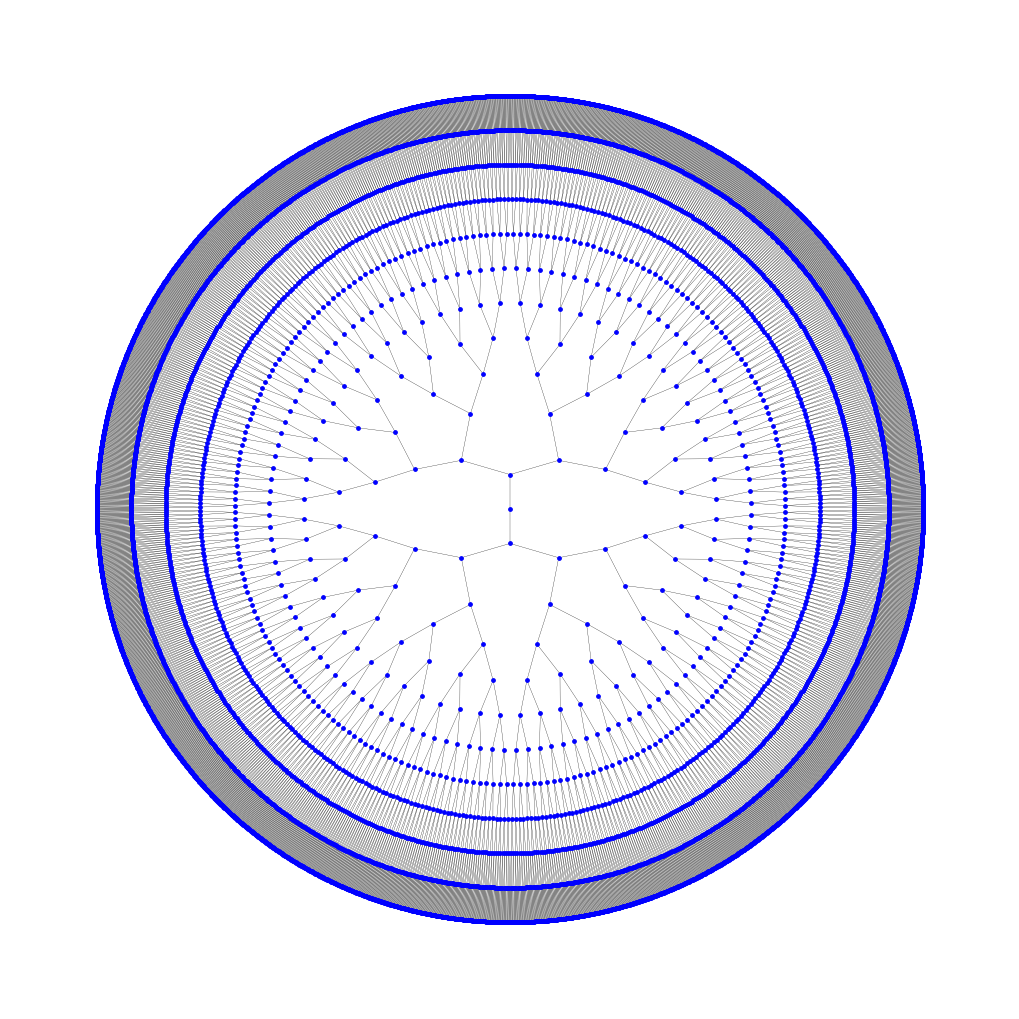

In [43]:
import math

import matplotlib.pyplot as plt
import networkx as nx

def add_nodes_edges(G: nx.Graph, node: BOM | None):
    if node is None:
        return

    G.add_node(node.id, label=node.name)
    if node.child_a is not None:
        G.add_edge(node.id, node.child_a.id)
        add_nodes_edges(G, node.child_a)

    if node.child_b is not None:
        G.add_edge(node.id, node.child_b.id)
        add_nodes_edges(G, node.child_b)

def hierarchical_tree_layout(G, root_node):
    pos = {}

    # Build adjacency list from the graph
    adj = {node: list(G.neighbors(node)) for node in G.nodes()}

    # BFS to determine levels and children
    from collections import deque
    queue = deque([(root_node, 0)])
    visited = {root_node}
    levels = {}
    children = {node: [] for node in G.nodes()}

    while queue:
        node, level = queue.popleft()
        levels[node] = level

        for neighbor in adj[node]:
            if neighbor not in visited:
                visited.add(neighbor)
                children[node].append(neighbor)
                queue.append((neighbor, level + 1))

    # Position nodes level by level
    def position_subtree(node, level, angle_start, angle_end):
        # Position current node
        if level == 0:
            pos[node] = (0, 0)  # Root at center
        else:
            angle = (angle_start + angle_end)
            radius = level * 0.8  # Increase radius per level
            x = radius * math.cos(angle)
            y = radius * math.sin(angle)
            pos[node] = (x, y)

        # Position children
        kids = children[node]
        if kids:
            angle_span = min(angle_end - angle_start, 2 * math.pi / max(1, len(kids)))
            angle_per_child = angle_span / len(kids)

            for i, child in enumerate(kids):
                child_angle_start = angle_start + i * angle_per_child
                child_angle_end = child_angle_start + angle_per_child
                position_subtree(child, level + 1, child_angle_start, child_angle_end)

    # Start positioning from root
    position_subtree(root_node, 0, 0, 2 * math.pi)
    return pos


G = nx.Graph()
add_nodes_edges(G, recovered_root)

plt.figure(figsize=(10, 10))
nx.draw(G, hierarchical_tree_layout(G, recovered_root.id),
    node_size=6, width=0.2, node_color="blue",
    with_labels=node_count<1200,
    labels=nx.get_node_attributes(G, "label"),
    )
plt.show()

# Meta
Meta Data about the table models are stored on the _meta attribute of the model class.


In [44]:
from tuplesaver.model import Row, get_meta
_meta = get_meta(Team)
assert Team._meta is _meta # type: ignore

_meta

Meta(Model=<class '__main__.Team'>, model_name='Team', table_name='Team', fields=(MetaField(name='id', type=<class 'int'>, full_type=int | None, nullable=True, is_fk=False, is_pk=True, sql_typename='INTEGER', sql_columndef='id [INTEGER] PRIMARY KEY NOT NULL'), MetaField(name='teamname', type=<class 'str'>, full_type=<class 'str'>, nullable=False, is_fk=False, is_pk=False, sql_typename='TEXT', sql_columndef='teamname [TEXT] NOT NULL'), MetaField(name='league', type=<class '__main__.League'>, full_type=<class '__main__.League'>, nullable=False, is_fk=True, is_pk=False, sql_typename='League_ID', sql_columndef='league [League_ID] NOT NULL')))